# Домашнее задание 5.2

По итоговому датасету:

1. Преобразовать текстовые данные (очистка + токенизация + нормализация).
2. Обучить модель **Word2Vec** на текстах.
3. Заполнить пропуски в числовых признаках через **SimpleImputer**.
4. Выбрать алгоритм **кластеризации** и построить кластеры.
5. Построить модель для **предсказания кластера** (supervised) с подбором гиперпараметров через **GridSearchCV**.


In [ ]:
!pip install pymorphy3 gensim scikit-learn nltk # бибилотеки с которыми будем работать

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 107.4 MB/s eta 0:00:00


In [ ]:
# Базовые импорты
import pandas as pd
import numpy as np


In [ ]:
import sqlite3
conn = sqlite3.connect("dvnovosti.db")
df = pd.read_sql_query("SELECT * FROM articles;", conn)
conn.close()



In [ ]:
df.head()

,guid,title,description,url,published_at,comments_count,created_at_utc,rating
0,5ca17d9b-a16b-495c-9937-224272159bcf,Экс‑руководитель шанхайской энергокорпорации п...,ИА SakhaNews. Шанхайский народный суд первой с...,https://1sn.ru/eksrukovoditel-sanxaiskoi-energ...,2026-01-13,0,2026-01-14 18:24:53,0.0
1,24b583cf-1e0e-4ad9-ab85-5866deb7efe7,Законопроект об аннексии Гренландии внесён в П...,ИА SakhaNews. Член Палаты представителей Конгр...,https://1sn.ru/zakonoproekt-ob-anneksii-grenla...,2026-01-13,2,2026-01-14 18:24:55,0.0
2,84ace3e0-74fa-4b0e-9d5d-4d4a6fc93313,Объем экспортных контрактов на военную технику...,ИА SakhaNews. Портфель подписанных Россией ору...,https://1sn.ru/obem-eksportnyx-kontraktov-na-v...,2026-01-12,0,2026-01-14 18:24:57,0.0
3,9bdabe05-6b88-4e27-af7f-8b1216e77cde,Насколько велик риск военного конфликта ЕС и РФ?,ИА SakhaNews. ЕС может попытаться заблокироват...,https://1sn.ru/naskolko-velik-risk-voennogo-ko...,2026-01-12,0,2026-01-14 18:24:59,0.0
4,0f201644-0375-4c93-b854-df08a928feed,Новогодние каникулы проходили в Якутске «под о...,ИА SakhaNews. Деятельность по пресечению и пре...,https://1sn.ru/novogodnie-kanikuly-proxodili-v...,2026-01-12,0,2026-01-14 18:25:00,0.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5499 entries, 0 to 5498
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   guid            5499 non-null   object 
 1   title           5499 non-null   object 
 2   description     5499 non-null   object 
 3   url             5499 non-null   object 
 4   published_at    5499 non-null   object 
 5   comments_count  5499 non-null   int64  
 6   created_at_utc  5499 non-null   object 
 7   rating          5499 non-null   float64
dtypes: float64(1), int64(1), object(6)
memory usage: 343.8+ KB


## Предобработка

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from pymorphy3 import MorphAnalyzer
nltk.download("stopwords")

# Инициализируем морфоанализатор и список стоп-слов
morph = MorphAnalyzer()
RUSSIAN_STOPWORDS = set(stopwords.words("russian"))

# Регулярка для выделения слов (русские и латинские буквы)
TOKEN_RE = re.compile(r"[А-Яа-яA-Za-z]+", flags=re.U)


def preprocess_text(text: str):
    """
    Полная предобработка одного текста:
    - приведение к нижнему регистру,
    - выделение токенов,
    - фильтрация по длине и стоп-словам,
    - лемматизация через pymorphy3.

    Возвращает список лемм (строк).
    """
    if not isinstance(text, str):
        text = "" if text is None else str(text)

    text = text.lower()
    tokens = TOKEN_RE.findall(text)

    lemmas = []
    for token in tokens:
        # Отсекаем короткий мусор
        if len(token) <= 2:
            continue

        # Русские и латинские слова отдельно
        if re.match(r"[а-я]", token):
            # Русское слово: нормальная форма через pymorphy3
            if token in RUSSIAN_STOPWORDS:
                continue
            parsed = morph.parse(token)[0]
            lemma = parsed.normal_form
            if lemma in RUSSIAN_STOPWORDS:
                continue
        else:
            # Латинское/английское слово — оставляем как есть
            lemma = token

        lemmas.append(lemma)

    return lemmas

text_col = "description"  # ваша текстовая колонка
tokenized_texts = df[text_col].astype(str).apply(preprocess_text).tolist()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:

sample_text = df["description"].iloc[0]
print(sample_text[:100], "...")

preprocess_text(sample_text)[:100]

ИА SakhaNews. Шанхайский народный суд первой ступени вынес смертный приговор бывшему председателю Ша ...


['sakhanews',
 'шанхайский',
 'народный',
 'суд',
 'первый',
 'ступень',
 'вынести',
 'смертный',
 'приговор',
 'бывший',
 'председатель',
 'шанхайский',
 'электроэнергетический',
 'корпорация',
 'чжэн',
 'цзяньхуа',
 'взяточничество',
 'нецелевой',
 'использование',
 'государственный',
 'средство',
 'сообщить',
 'издание',
 'пэнпай',
 'суд',
 'постановить',
 'вынести',
 'смертный',
 'приговор',
 'отсрочка',
 'исполнение',
 'приговор',
 'год',
 'истечение',
 'двухлетний',
 'срок',
 'приговор',
 'заменить',
 'пожизненный',
 'заключение',
 'это',
 'время',
 'осудить',
 'совершить',
 'иной',
 'преступление',
 'чжэн',
 'цзяньхуа',
 'пожизненно',
 'лишить',
 'политический',
 'право',
 'оштрафовать',
 'тыс',
 'юань',
 'тыс',
 'доллар',
 'имущество',
 'конфисковать',
 'чжэн',
 'цзяньхуа',
 'присваивать',
 'государственный',
 'средство',
 'давать',
 'долг',
 'лицо',
 'порядок',
 'млн',
 'юань',
 'около',
 'млн',
 'доллар',
 'возвратить',
 'суд',
 'заявить',
 'нанести',
 'серьёзный',
 'ущерб',


In [ ]:
N_DOCS = 5000  # для демонстрации; нужно увеличить до len(df)

texts = df["description"].iloc[:N_DOCS].tolist()

tokenized_texts = [preprocess_text(t) for t in texts]

# Смотрим пример
tokenized_texts[0][:40]

['sakhanews',
 'шанхайский',
 'народный',
 'суд',
 'первый',
 'ступень',
 'вынести',
 'смертный',
 'приговор',
 'бывший',
 'председатель',
 'шанхайский',
 'электроэнергетический',
 'корпорация',
 'чжэн',
 'цзяньхуа',
 'взяточничество',
 'нецелевой',
 'использование',
 'государственный',
 'средство',
 'сообщить',
 'издание',
 'пэнпай',
 'суд',
 'постановить',
 'вынести',
 'смертный',
 'приговор',
 'отсрочка',
 'исполнение',
 'приговор',
 'год',
 'истечение',
 'двухлетний',
 'срок',
 'приговор',
 'заменить',
 'пожизненный',
 'заключение']

## Обучение модели

In [ ]:
from gensim.models import Word2Vec
import numpy as np

w2v = Word2Vec(
    sentences=tokenized_texts,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
    sg=1,
    epochs=10,
)

def doc_vector(tokens, model):
    vecs = [model.wv[t] for t in tokens if t in model.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(model.vector_size)

doc_vectors = np.vstack([doc_vector(t, w2v) for t in tokenized_texts])
doc_vectors.shape


(5000, 100)

In [ ]:
w2v.wv.most_similar("якутск", topn=10)

[('город', 0.6957975625991821),
 ('кангаласс', 0.6283618211746216),
 ('якутскгеология', 0.6273112297058105),
 ('губинский', 0.6247352361679077),
 ('нерюнгри', 0.6226937770843506),
 ('общегородской', 0.6221359372138977),
 ('попечительство', 0.6016669869422913),
 ('алексеенко', 0.6004460453987122),
 ('гудошник', 0.5990762710571289),
 ('умеренко', 0.5982269048690796)]

## Обработка числовых признаков

In [ ]:
from sklearn.impute import SimpleImputer

num_cols = ["comments_count", "rating"]  # числовые фичи
numeric = df[num_cols].values

imputer = SimpleImputer(strategy="median")
numeric_imputed = imputer.fit_transform(numeric)
numeric_imputed.shape


(5499, 2)

## Кластеризация


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)

doc_vectors_2d = pca.fit_transform(doc_vectors)
doc_vectors_2d[:5]

df_subset = df.iloc[:N_DOCS].copy()
df_subset["pca_x"] = doc_vectors_2d[:, 0]
df_subset["pca_y"] = doc_vectors_2d[:, 1]

df_subset.head()

,guid,title,description,url,published_at,comments_count,created_at_utc,rating,pca_x,pca_y
0,5ca17d9b-a16b-495c-9937-224272159bcf,Экс‑руководитель шанхайской энергокорпорации п...,ИА SakhaNews. Шанхайский народный суд первой с...,https://1sn.ru/eksrukovoditel-sanxaiskoi-energ...,2026-01-13,0,2026-01-14 18:24:53,0.0,-0.221844,0.037367
1,24b583cf-1e0e-4ad9-ab85-5866deb7efe7,Законопроект об аннексии Гренландии внесён в П...,ИА SakhaNews. Член Палаты представителей Конгр...,https://1sn.ru/zakonoproekt-ob-anneksii-grenla...,2026-01-13,2,2026-01-14 18:24:55,0.0,-0.576480,0.154921
2,84ace3e0-74fa-4b0e-9d5d-4d4a6fc93313,Объем экспортных контрактов на военную технику...,ИА SakhaNews. Портфель подписанных Россией ору...,https://1sn.ru/obem-eksportnyx-kontraktov-na-v...,2026-01-12,0,2026-01-14 18:24:57,0.0,-0.106335,0.080007
3,9bdabe05-6b88-4e27-af7f-8b1216e77cde,Насколько велик риск военного конфликта ЕС и РФ?,ИА SakhaNews. ЕС может попытаться заблокироват...,https://1sn.ru/naskolko-velik-risk-voennogo-ko...,2026-01-12,0,2026-01-14 18:24:59,0.0,-0.598750,-0.111396
4,0f201644-0375-4c93-b854-df08a928feed,Новогодние каникулы проходили в Якутске «под о...,ИА SakhaNews. Деятельность по пресечению и пре...,https://1sn.ru/novogodnie-kanikuly-proxodili-v...,2026-01-12,0,2026-01-14 18:25:00,0.0,0.096967,-0.022917


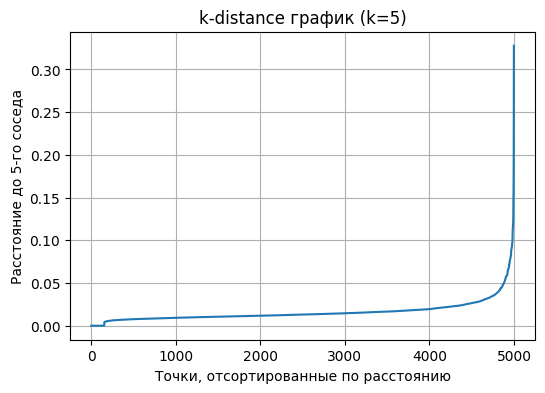

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

X_for_dbscan = doc_vectors_2d  # или другие признаки
k = 5  # это min_samples

# 1–2. считаем расстояния до k-го соседа
neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(X_for_dbscan)
distances, indices = neigh.kneighbors(X_for_dbscan)

# расстояние до k-го соседа (столбец k-1)
k_distances = np.sort(distances[:, k-1])

# 3–4. строим график
plt.figure(figsize=(6, 4))
plt.plot(k_distances)
plt.title(f"k-distance график (k={k})")
plt.xlabel("Точки, отсортированные по расстоянию")
plt.ylabel(f"Расстояние до {k}-го соседа")
plt.grid(True)
plt.show()


In [ ]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.025, min_samples=5)


cluster_labels = dbscan.fit_predict(doc_vectors_2d)

# -1 в DBSCAN означает "шум"
np.unique(cluster_labels, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
 array([ 352, 4223,   47,   15,   12,    9,    6,   20,    5,  155,   20,
          16,    8,    6,    6,    6,   21,    4,   12,    5,    7,    7,
           5,   12,    6,    5,    5,    5]))

In [ ]:
df_subset["cluster"] = cluster_labels
df_subset[["title", "cluster"]].head(10)

,title,cluster
0,Экс‑руководитель шанхайской энергокорпорации п...,0
1,Законопроект об аннексии Гренландии внесён в П...,0
2,Объем экспортных контрактов на военную технику...,0
3,Насколько велик риск военного конфликта ЕС и РФ?,-1
4,Новогодние каникулы проходили в Якутске «под о...,0
5,Участник СВО назначен на должность регионально...,0
6,"Трамп: США намерены завладеть Гренландией, ина...",0
7,Якутские антиБазаровы «хотят понравиться»?,0
8,"Трамп пригрозил, что на Кубу не будут поступат...",0
9,Передача Нобелевской премии «из рук в руки» не...,0


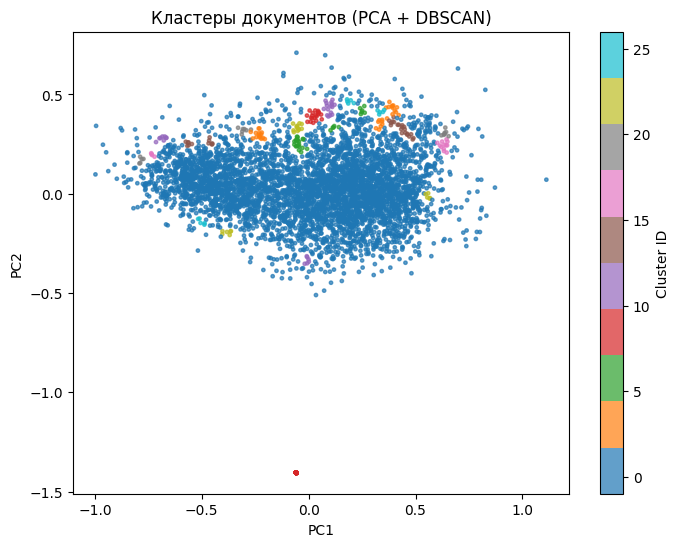

In [ ]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    df_subset["pca_x"],
    df_subset["pca_y"],
    c=df_subset["cluster"],
    s=6,
    cmap="tab10",
    alpha=0.7,
)
plt.colorbar(scatter, label="Cluster ID")
plt.title("Кластеры документов (PCA + DBSCAN)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [ ]:
cluster_id = 5

df_subset[df_subset["cluster"] == cluster_id][["title"]].head(10)

,title
224,Якутянин назначен главой МВД по Сахалинской об...
418,Сенатором от правительства ЕАО станет замминис...
1251,Депутат Госдумы назначен заместителем министра...
2452,Хасиков вновь поборется за должность главы Кал...
2777,В Бурятии отказались от прямых выборов мэра ст...
4924,Глава правительства ДНР получил назначение вр...


In [ ]:
cluster_id = 18

df_subset[df_subset["cluster"] == cluster_id][["title"]].head(10)

,title
39,Лидеры России и США провели новый разговор по ...
621,Трамп стремится покончить с финансированием ко...
987,Индия нанесла удар по Пакистану
1863,"ЦАХАЛ обещает нанести по Ирану «смертоносный, ..."
3562,В США оценили потери ВСУ в 190 тысяч человек у...


## Предсказать кластеры методом DecisionTree

In [ ]:
mask_non_noise = df_subset["cluster"] != -1
df_sup = df_subset[mask_non_noise].copy()

print(
    "Всего объектов для supervised-задачи:",
    len(df_sup),
    "из",
    len(df_subset),
)

# Целевая переменная — номер кластера
y = df_sup["cluster"].astype(int)

y.value_counts().sort_index()


Всего объектов для supervised-задачи: 4767 из 5000


,count
cluster,
0,4536
1,155
2,8
3,11
4,6
5,5
6,5
7,6
8,9


In [ ]:
numeric_features = df_sup[["comments_count", "rating"]].copy()

imputer = SimpleImputer(strategy="median")

numeric_imputed = imputer.fit_transform(numeric_features)
numeric_imputed[:5]

array([[0., 0.],
       [2., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [ ]:

# Индексы документов, которые попали в df_sup
idx = df_sup.index.to_numpy()

# Берём соответствующие векторы документов
doc_vectors_sup = doc_vectors[idx]

# Собираем общий набор признаков
X_features = np.hstack([doc_vectors_sup, numeric_imputed])
X_features.shape


(4767, 102)

In [ ]:
X = X_features
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

X_train.shape, X_test.shape

((3813, 102), (954, 102))

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

X = X_features  # Уже готово: (N, 102) гибридные признаки
y = df_sup["cluster"].astype(int)

print("Форма данных:", X.shape)
print("Классы:", np.unique(y, return_counts=True))
print(f"Объектов для обучения: {len(y)}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,  # 70% train, 30% test
    random_state=42,
    stratify=y
)

print("Train/Test формы:", X_train.shape, X_test.shape)

dt = DecisionTreeClassifier(random_state=42)

param_grid = {
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
    "criterion": ["gini", "entropy"],
}

grid_dt = GridSearchCV( # тюнинг
    estimator=dt,
    param_grid=param_grid,
    scoring="accuracy",
    cv=3,           # 3-fold кросс-валидация
    n_jobs=-1,      # Все ядра CPU
)

grid_dt.fit(X_train, y_train)

print("Лучшие параметры:", grid_dt.best_params_)
print("Лучший CV accuracy:", grid_dt.best_score_)

best_dt = grid_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test)

print("Test accuracy:", accuracy_score(y_test, y_pred_dt))
print("\nClassification report (Decision Tree):")
print(classification_report(y_test, y_pred_dt))

Форма данных: (4767, 102)
Классы: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]), array([4536,  155,    8,   11,    6,    5,    5,    6,    9,    6,    5,
          5,    5,    5]))
Объектов для обучения: 4767
Train/Test формы: (3336, 102) (1431, 102)
Лучшие параметры: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10}
Лучший CV accuracy: 0.9808153477218226
Test accuracy: 0.9811320754716981

Classification report (Decision Tree):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1362
           1       0.98      1.00      0.99        47
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         2
           8       0.00   

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Предсказать кластеры методом KNN

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

X = X_features
y = df_sup["cluster"].astype(int)

print("Форма данных:", X.shape)
print("Классы:", np.unique(y, return_counts=True))
print(f"Объектов для обучения: {len(y)}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("Train/Test формы:", X_train.shape, X_test.shape)

knn = KNeighborsClassifier()

param_grid = {
    "n_neighbors": [3, 5, 10, 15],      # Количество соседей
    "weights": ["uniform", "distance"],  # uniform=равный вес, distance=1/расстояние
    "metric": ["cosine", "euclidean"],
}

grid = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
)

grid.fit(X_train, y_train)

print("Лучшие параметры:", grid.best_params_)
print("Лучший CV accuracy:", grid.best_score_)

best_knn = grid.best_estimator_
y_pred = best_knn.predict(X_test)

print("Test accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report (KNN):")
print(classification_report(y_test, y_pred))



Форма данных: (4767, 102)
Классы: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]), array([4536,  155,    8,   11,    6,    5,    5,    6,    9,    6,    5,
          5,    5,    5]))
Объектов для обучения: 4767
Train/Test формы: (3336, 102) (1431, 102)
Лучшие параметры: {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'uniform'}
Лучший CV accuracy: 0.9823141486810552
Test accuracy: 0.9825296995108316

Classification report (KNN):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1362
           1       1.00      0.94      0.97        47
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         3
   

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
